In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import LabelEncoder
import sklearn.linear_model as linear_model
from scipy import stats
from scipy.stats import skew,norm  # for some statistics
from scipy.special import boxcox1p
%matplotlib inline
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import  GradientBoostingClassifier,RandomForestClassifier
import lightgbm as lgbm
import xgboost as xgb
from catboost import CatBoostClassifier

from sklearn.linear_model import  LinearRegression, Ridge
import os, gc, warnings
warnings.filterwarnings('ignore')

In [2]:
ttrain = pd.read_csv('Train.csv')
ttest = pd.read_csv('Test.csv')

In [3]:
submission = pd.read_csv("SampleSubmission.csv")

In [4]:
fin_data = pd.concat([ttrain,ttest]).reset_index(drop=True)

In [5]:
fin_data.drop(['Target'],axis =1, inplace = True)

## DEALING WITH MISSING VALUES

In [6]:
fin_data.isnull().sum()

ID                   0
country_code         0
region               0
age                451
FQ1                  0
FQ2              84998
FQ3              88777
FQ4                  0
FQ5             124825
FQ6              68386
FQ7              68386
FQ8                  0
FQ9                  0
FQ10                 0
FQ11             35135
FQ12                 0
FQ13                 0
FQ14                 0
FQ15                 0
FQ16                 0
FQ17            138698
FQ18                 0
FQ19             67764
FQ20             35135
FQ21             35135
FQ22                 0
FQ23                 0
FQ24             99926
FQ35            117982
FQ36            138540
FQ25                 0
FQ26                 0
FQ27            150280
FQ28            152786
FQ29             35135
FQ30            151932
FQ31            153690
FQ32             68127
FQ33                 2
FQ34             45135
FQ37                 0
dtype: int64

In [7]:
list = []
for i in fin_data.columns:
    kd = fin_data[i].isna().sum()
    ml = len(fin_data[i])
    jd = kd/ml * 100
    
    
    if jd > 70:
        fin_data.drop(i, axis = 1, inplace = True)
        list.append(i)
        
        
        """ Dropping fetaures with missing values greater than 70% """

In [8]:
fin_data['age'].fillna(fin_data['age'].median(), inplace = True) ## replaced the missing value in age with the median
## median is robust to outliers.

In [9]:
def fill(col):
    for i in col:
        #fin_data[i].fillna(fin_data[i].mode()[0], inplace = True)
        #fin_data[i].astype(str)
        fin_data[i].fillna(9999, inplace = True)
        
        """ Filling up the remaining features with a very large number """

In [10]:
fill(fin_data.drop(["ID","country_code"],axis=1))

## OUTLIER REMOVAL IN THE AGE FEATURE

In [11]:
fin_data['age'] = np.log1p(fin_data['age'])

In [12]:
numerical = fin_data.dtypes[fin_data.dtypes != 'object'].index

skewness = fin_data[numerical].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)

skewness_df = pd.DataFrame({'Skewness': skewness})
skewness_df.head(10)

,Skewness
FQ33,278.262224
FQ11,1.304865
FQ29,1.304865
FQ20,1.304865
FQ21,1.304865
FQ34,0.918448
FQ18,0.911484
FQ22,0.647726
FQ19,0.252368
FQ32,0.242779


In [13]:
(abs(skewness) > 0.75).value_counts()

False    18
True     14
dtype: int64

In [14]:
from scipy.special import boxcox1p

boxcox_features = skewness_df[np.abs(skewness_df['Skewness'])>0.75].index
lam = 0.5

for col in boxcox_features:
    fin_data.loc[:, col] = boxcox1p(fin_data[col], lam)

In [15]:
skewness2 = fin_data[numerical].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)

skewness_df2 = pd.DataFrame({'Skewness': skewness2})
skewness_df2.head(10)

,Skewness
FQ33,233.349629
FQ11,1.304843
FQ29,1.304842
FQ20,1.304836
FQ21,1.304833
FQ34,0.918434
FQ18,0.698322
FQ22,0.647726
FQ19,0.252368
FQ32,0.242779


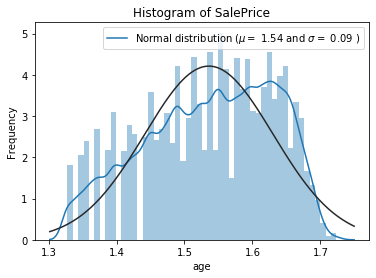

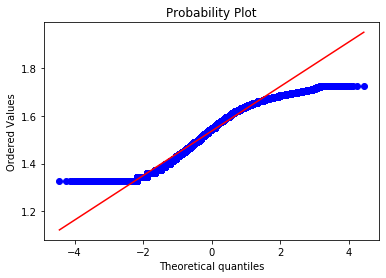

In [16]:
from scipy.stats import norm, skew, probplot

fin_data['age'] = np.log1p(fin_data['age'])

mu, sigma = norm.fit(fin_data['age'])
sns.distplot(fin_data['age'], fit=norm)
plt.legend(['Normal distribution ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc = 'best')
plt.ylabel('Frequency')
plt.title('Histogram of SalePrice');

fig = plt.figure()
res = probplot(fin_data['age'], plot=plt);

In [17]:
cat_col = fin_data.select_dtypes(include=[np.object]).columns
cat_col

Index(['ID'], dtype='object')

In [18]:
#fin_data['region'] = fin_data['region'].astype(str)
# fin_data['country_code'] = fin_data['country_code'].astype(str)

In [19]:
#from sklearn.preprocessing import LabelEncoder
#le = LabelEncoder()
#fin_data['region'] = le.fit_transform(fin_data['region'])
#fin_data['country_code'] = le.fit_transform(fin_data['country_code'])

In [20]:
#for i in col:
#    fin_data[i] = le.fit_transform(fin_data[i])

In [21]:
fin_data.drop(['ID'],axis =1, inplace = True)

In [22]:
skf = StratifiedKFold(n_splits = 5, shuffle = True, random_state=99)

In [23]:
split=ttrain.shape[0]
train_df=fin_data[:split]
test_df=fin_data[split:]

In [24]:
X = train_df
y = ttrain['Target']
X = X.astype('float')
y = pd.DataFrame(y, dtype = float)

In [25]:
X.head()

,country_code,region,age,FQ1,FQ2,FQ3,FQ4,FQ6,FQ7,FQ8,...,FQ22,FQ23,FQ24,FQ25,FQ26,FQ29,FQ32,FQ33,FQ34,FQ37
0,1.0,6.0,1.522467,2.0,9999.0,9999.0,2.0,9999.0,1.0,1.464102,...,1.0,2.0,9999.0,1.464102,1.464102,0.828427,9999.0,0.828427,0.828427,0.0
1,32.0,7.0,1.660640,2.0,9999.0,9999.0,2.0,9999.0,1.0,1.464102,...,1.0,2.0,9999.0,0.828427,0.828427,1.464102,9999.0,0.828427,1.464102,0.0
2,71.0,7.0,1.419607,2.0,1.0,9999.0,2.0,9999.0,1.0,1.464102,...,1.0,2.0,9999.0,1.464102,0.828427,1.464102,9999.0,1.464102,0.828427,1.0
3,48.0,3.0,1.466077,1.0,9999.0,9999.0,2.0,2.0,9999.0,1.464102,...,1.0,2.0,9999.0,1.464102,1.464102,198.000000,2.0,0.828427,0.828427,1.0
4,25.0,0.0,1.683065,2.0,9999.0,9999.0,2.0,9999.0,9999.0,1.464102,...,1.0,1.0,2.0,1.464102,1.464102,1.464102,2.0,0.828427,0.828427,1.0


In [26]:
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3,random_state=19)

In [27]:
#from catboost import Pool
#cat_model= CatBoostClassifier(silent=True, eval_metric = 'AUC')
#cat_model= CatBoostClassifier(silent=True, n_estimators= 660, learning_rate=0.2, depth =3, eval_metric = 'AUC',l2_leaf_reg= 3)
#cat_model.fit(Pool(X_train,y_train))
#cat = cat_model.predict_proba(X_test)[:,1]

In [28]:
#print(roc_auc_score(y_test,cat))
#print(classification_report(y_test,cat))

In [29]:
#predictions = cat_model.predict_proba(test_df)[:,1]
#sub= ttest[["ID"]]
#sub['Target'] = predictions
#sub.to_csv('cat.csv', index = False)

## MODELS

In [30]:
def model(model,train,label,test,model_name):
    mean_train = []
    mean_test = []
    test_pred = np.zeros(test.shape[0])
    val_pred = np.zeros(train.shape[0])
    for count, (train_index,test_index) in enumerate(skf.split(train,label)):
        x_train,x_test = train.iloc[train_index],train.iloc[test_index]
        y_train,y_test = label.iloc[train_index],label.iloc[test_index]
        print(f'========================Fold{count +1}==========================')
        model.fit(x_train, y_train)
        train_predict = model.predict_proba(x_train)[:,1]
        test_predict = model.predict_proba(x_test)[:,1]
        val_pred[test_index] = test_predict
        test_pred+= model.predict_proba(test)[:,1]
        
        print('\nValidation scores', roc_auc_score(y_test,test_predict))
        print('\nTraining scores', roc_auc_score(y_train,train_predict))
        mean_train.append(roc_auc_score(y_train, train_predict))
        mean_test.append(roc_auc_score(y_test,test_predict))
    print('Average Testing ROC score for 10 folds split:',np.mean(mean_test))
    print('Average Training ROC score for 10 folds split:',np.mean(mean_train))
    print('standard Deviation for 10 folds split:',np.std(mean_test))
    return val_pred, test_pred, model_name
        
def Stacking(model,Train_stack,Test_stack,target,file_name):
    prediction = model.fit(Train_stack, target).predict(Test_stack)
    submission['Target'] = prediction
    submission.to_csv(file_name,index=False)

## LGBM 1

In [31]:
def lgb(model,train,label,test,model_name):
    mean_train = []
    mean_test = []
    test_pred = np.zeros(test.shape[0])
    val_pred = np.zeros(train.shape[0])
    for count, (train_index,test_index) in enumerate(skf.split(train,label)):
        x_train,x_test = train.iloc[train_index],train.iloc[test_index]
        y_train,y_test = label.iloc[train_index],label.iloc[test_index]
        print(f'========================Fold{count +1}==========================')
        model.fit(x_train,y_train,eval_set=[(x_test,y_test)],early_stopping_rounds=500,
                               verbose=250)
        train_predict = model.predict_proba(x_train, num_iteration = model.best_iteration_)[:,1]
        test_predict = model.predict_proba(x_test, num_iteration = model.best_iteration_)[:,1]
        val_pred[test_index] = test_predict
        test_pred+= model.predict_proba(test, num_iteration = model.best_iteration_)[:,1]
        
        print('\nValidation scores', roc_auc_score(y_test,test_predict))
        print('\nTraining scores', roc_auc_score(y_train,train_predict))
        mean_train.append(roc_auc_score(y_train, train_predict))
        mean_test.append(roc_auc_score(y_test,test_predict))
    print('Average Testing ROC score for 10 folds split:',np.mean(mean_test))
    print('Average Training ROC score for 10 folds split:',np.mean(mean_train))
    print('standard Deviation for 10 folds split:',np.std(mean_test))
    return val_pred, test_pred, model_name

In [32]:
lgb_model = lgbm.LGBMClassifier(random_state=34, n_estimators=8000, num_leaves=35,reg_lambda=6,reg_alpha=6 ,metric='auc', learning_rate=0.08,
    max_depth=-1, class_weight = 'balanced')
LGB1_train, LGB1_test, LGB1_name =lgb(lgb_model,X, y, test_df,'lightgbm(1)')


========================Fold1==========================
Training until validation scores don't improve for 500 rounds
[250]	valid_0's auc: 0.503235
[500]	valid_0's auc: 0.499443
Early stopping, best iteration is:
[7]	valid_0's auc: 0.512332

Validation scores 0.512332474654088

Training scores 0.5562688891343058
========================Fold2==========================
Training until validation scores don't improve for 500 rounds
[250]	valid_0's auc: 0.496244
[500]	valid_0's auc: 0.498709
Early stopping, best iteration is:
[94]	valid_0's auc: 0.502107

Validation scores 0.5021065704105201

Training scores 0.6549186937161524
========================Fold3==========================
Training until validation scores don't improve for 500 rounds
[250]	valid_0's auc: 0.501909
[500]	valid_0's auc: 0.50106
[750]	valid_0's auc: 0.501146
Early stopping, best iteration is:
[327]	valid_0's auc: 0.50264

Validation scores 0.5026400074879762

Training scores 0.7429897876126108
========================F

## LGBM 2

In [33]:
lgb_model2 = lgbm.LGBMClassifier(random_state=34, n_estimators=5000,colsample_bytree=0.9,min_child_samples=10,
    subsample=0.5,subsample_freq=2,num_leaves=120,reg_lambda=2,reg_alpha=5 ,metric='auc', learning_rate=0.008,
    max_depth=5)
LGBM2_train, LGBM2_test, LGBM2_name= lgb(lgb_model2,X,y,test_df,'lightgbm(2)')

========================Fold1==========================
Training until validation scores don't improve for 500 rounds
[250]	valid_0's auc: 0.498779
[500]	valid_0's auc: 0.500601
Early stopping, best iteration is:
[4]	valid_0's auc: 0.506768

Validation scores 0.5067678625697755

Training scores 0.530132448494461
========================Fold2==========================
Training until validation scores don't improve for 500 rounds
[250]	valid_0's auc: 0.492977
[500]	valid_0's auc: 0.495999
Early stopping, best iteration is:
[28]	valid_0's auc: 0.499139

Validation scores 0.4991389960276662

Training scores 0.5645391822761556
========================Fold3==========================
Training until validation scores don't improve for 500 rounds
[250]	valid_0's auc: 0.492815
[500]	valid_0's auc: 0.49518
Early stopping, best iteration is:
[1]	valid_0's auc: 0.501533

Validation scores 0.5015331413160776

Training scores 0.5178267893284146
========================Fold4==========================


## CATBOOST 1

In [34]:
def cat(model,train,label,test,model_name):
    mean_train = []
    mean_test = []
    test_pred = np.zeros(test.shape[0])
    val_pred = np.zeros(train.shape[0])
    for count, (train_index,test_index) in enumerate(skf.split(train,label)):
        x_train,x_test = train.iloc[train_index],train.iloc[test_index]
        y_train,y_test = label.iloc[train_index],label.iloc[test_index]
        print(f'========================Fold{count +1}==========================')
        model.fit(x_train,y_train,eval_set=[(x_test,y_test)],early_stopping_rounds=500,
                           verbose=250,use_best_model=True)
        train_predict = model.predict_proba(x_train)[:,1]
        test_predict = model.predict_proba(x_test)[:,1]
        val_pred[test_index] = test_predict
        test_pred+= model.predict_proba(test)[:,1]
        
        print('\nTesting scores', roc_auc_score(y_test,test_predict))
        print('\nTraining scores', roc_auc_score(y_train,train_predict))
        mean_train.append(roc_auc_score(y_train, train_predict))
        mean_test.append(roc_auc_score(y_test,test_predict))
    print('Average Testing ROC score for 8 folds split:',np.mean(mean_test))
    print('Average Training ROC score for 8 folds split:',np.mean(mean_train))
    print('standard Deviation for 8 folds split:',np.std(mean_test))
    return val_pred, test_pred, model_name


In [35]:
catboost =  CatBoostClassifier(random_seed=34,use_best_model=True,
                          n_estimators=5000,silent=True,eval_metric='AUC')

cat1_train, cat1_test, cat1_name = cat(catboost,X,y,test_df,'catboost(1)')

========================Fold1==========================
Learning rate set to 0.047382
0:	test: 0.5013594	best: 0.5013594 (0)	total: 100ms	remaining: 8m 21s
250:	test: 0.5053124	best: 0.5053971 (248)	total: 9.89s	remaining: 3m 7s
500:	test: 0.5052478	best: 0.5073976 (424)	total: 19.5s	remaining: 2m 55s
750:	test: 0.5054503	best: 0.5073976 (424)	total: 30s	remaining: 2m 49s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.5073976041
bestIteration = 424

Shrink model to first 425 iterations.

Testing scores 0.5073976041375519

Training scores 0.6817653196357147
========================Fold2==========================
Learning rate set to 0.047383
0:	test: 0.5023512	best: 0.5023512 (0)	total: 34.3ms	remaining: 2m 51s
250:	test: 0.4964507	best: 0.5023512 (0)	total: 9.54s	remaining: 3m
500:	test: 0.4995829	best: 0.5023512 (0)	total: 19.8s	remaining: 2m 58s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.5023511929
bestIteration = 0

Shrink model to fir

## CATBOOST 2

In [36]:
catboost2 =  CatBoostClassifier(random_seed=34,bootstrap_type='Bayesian',max_depth=6,learning_rate=0.007,
                          iterations=8000,silent=True,eval_metric='AUC')


cat2_train, cat2_test, cat2_name = cat(catboost2,X,y,test_df,'catboost(2)')

========================Fold1==========================
0:	test: 0.5013594	best: 0.5013594 (0)	total: 42.9ms	remaining: 5m 43s
250:	test: 0.4970079	best: 0.5013594 (0)	total: 10.2s	remaining: 5m 15s
500:	test: 0.4947134	best: 0.5013594 (0)	total: 20.8s	remaining: 5m 10s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.5013593769
bestIteration = 0

Shrink model to first 1 iterations.

Testing scores 0.5013593768988537

Training scores 0.5132007571652667
========================Fold2==========================
0:	test: 0.5023512	best: 0.5023512 (0)	total: 35.6ms	remaining: 4m 44s
250:	test: 0.4929780	best: 0.5033928 (17)	total: 12.8s	remaining: 6m 33s
500:	test: 0.4927576	best: 0.5033928 (17)	total: 22.7s	remaining: 5m 40s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.5033927968
bestIteration = 17

Shrink model to first 18 iterations.

Testing scores 0.5033927968242876

Training scores 0.5417615391798823
========================Fold3=============

## RANDOM FOREST 1

In [37]:
rf1_model = RandomForestClassifier(n_jobs=-1,criterion='entropy',min_samples_split=10,n_estimators=400,random_state=99)
rf1_train, rf1_test, rf1_name = model(rf1_model,X,y,test_df,'RandomForest(1)')

========================Fold1==========================

Validation scores 0.49860843825704704

Training scores 1.0
========================Fold2==========================

Validation scores 0.4977623066454912

Training scores 1.0
========================Fold3==========================

Validation scores 0.49805097163180917

Training scores 1.0
========================Fold4==========================

Validation scores 0.4982781630527328

Training scores 1.0
========================Fold5==========================

Validation scores 0.4983658526570548

Training scores 1.0
Average Testing ROC score for 10 folds split: 0.49821314644882697
Average Training ROC score for 10 folds split: 1.0
standard Deviation for 10 folds split: 0.00028752709716033727


## RANDOM FOREST 2

In [38]:
rf_model2 = RandomForestClassifier(max_depth=10,min_samples_split=10,min_samples_leaf=15,n_estimators=400,n_jobs=-1,random_state=34)
rf2_train, rf2_test, rf2_name= model( rf_model2,X,y,test_df,'RandomForest(2)')

========================Fold1==========================

Validation scores 0.4998367837313435

Training scores 0.7914423695103342
========================Fold2==========================

Validation scores 0.4939552098387116

Training scores 0.7845598251088661
========================Fold3==========================

Validation scores 0.4906217651433213

Training scores 0.7705438320529066
========================Fold4==========================

Validation scores 0.4956410625205611

Training scores 0.7846783553861674
========================Fold5==========================

Validation scores 0.49670637632419584

Training scores 0.7882419575965502
Average Testing ROC score for 10 folds split: 0.49535223951162666
Average Training ROC score for 10 folds split: 0.7838932679309649
standard Deviation for 10 folds split: 0.0030449079379330957


In [39]:
#classifier = lgbm.LGBMClassifier()
#param_grid  = {'num_iterations': np.arange(100, 10000, 100),
               #'learning_rate':np.arange(0.001, 1, 0.001),
               #'max_depth = 10': np.arange(1, 20, 1),
               #'num_leaves':np.arange(1, 1000, 5),
              #'reg_lambda': np.arange(1,10,1),
              #'reg_alpha': np.arange(1,10,1)}

## XGBOOST

In [40]:
def xgb(model,train,label,test,model_name):
    mean_train = []
    mean_test = []
    test_pred = np.zeros(test.shape[0])
    val_pred = np.zeros(train.shape[0])
    for count, (train_index,test_index) in enumerate(skf.split(train,label)):
        x_train,x_test = train.iloc[train_index],train.iloc[test_index]
        y_train,y_test = label.iloc[train_index],label.iloc[test_index]
        print(f'========================Fold{count +1}==========================')
        model.fit(x_train, y_train, early_stopping_rounds = 500, eval_metric="auc",
                           eval_set=[(x_test, y_test)],verbose=250)
        train_predict = model.predict_proba(x_train, ntree_limit = model.get_booster().best_ntree_limit)[:,1]
        test_predict = model.predict_proba(x_test, ntree_limit = model.get_booster().best_ntree_limit)[:,1]
        val_pred[test_index] = test_predict
        test_pred+= model.predict_proba(test, ntree_limit = model.get_booster().best_ntree_limit)[:,1]
        
        print('\nTesting scores', roc_auc_score(y_test,test_predict))
        print('\nTraining scores', roc_auc_score(y_train,train_predict))
        mean_train.append(roc_auc_score(y_train, train_predict))
        mean_test.append(roc_auc_score(y_test,test_predict))
    print('Average Testing ROC score for 10 folds split:',np.mean(mean_test))
    print('Average Training ROC score for 10 folds split:',np.mean(mean_train))
    print('standard Deviation for 10 folds split:',np.std(mean_test))
    return val_pred, test_pred, model_name

In [44]:
from xgboost import XGBClassifier
Xgboost = XGBClassifier(learning_rate=0.5,subsample=0.7,colsample_bytree=0.9,reg_alpha=6,
               n_jobs=-1,n_estimators=5000,max_depth= 7,random_state=34)

xgb_train, xgb_test, xgb_name= xgb(Xgboost,X,y,test_df,'xgboost')

========================Fold1==========================
[0]	validation_0-auc:0.50000
Will train until validation_0-auc hasn't improved in 500 rounds.
[250]	validation_0-auc:0.49867
[500]	validation_0-auc:0.50016
Stopping. Best iteration:
[6]	validation_0-auc:0.50590


Testing scores 0.5058956340607161

Training scores 0.5613897522877155
========================Fold2==========================
[0]	validation_0-auc:0.50000
Will train until validation_0-auc hasn't improved in 500 rounds.
[250]	validation_0-auc:0.50092
[500]	validation_0-auc:0.50539
[750]	validation_0-auc:0.50264
Stopping. Best iteration:
[453]	validation_0-auc:0.50589


Testing scores 0.505889770330613

Training scores 0.9606352408923248
========================Fold3==========================
[0]	validation_0-auc:0.50000
Will train until validation_0-auc hasn't improved in 500 rounds.
[250]	validation_0-auc:0.50323
[500]	validation_0-auc:0.50003
Stopping. Best iteration:
[59]	validation_0-auc:0.50740


Testing scores 0.507

## GRADIENT BOOSTING

In [45]:
gbm_model = GradientBoostingClassifier(max_depth=4,min_samples_leaf=10,n_estimators=200,learning_rate=0.1,min_samples_split=10,random_state=10)
gbm_train, gbm_test, gbm_name= model(gbm_model,X,y,test_df, 'Gbm')

========================Fold1==========================

Validation scores 0.5053644879632263

Training scores 0.6222504613296113
========================Fold2==========================

Validation scores 0.49615057064931795

Training scores 0.622578233315992
========================Fold3==========================

Validation scores 0.49595028994426066

Training scores 0.6221885165793559
========================Fold4==========================

Validation scores 0.49601082302395355

Training scores 0.6196955361481137
========================Fold5==========================

Validation scores 0.5018818584519003

Training scores 0.6256853825145623
Average Testing ROC score for 10 folds split: 0.4990716060065317
Average Training ROC score for 10 folds split: 0.6224796259775272
standard Deviation for 10 folds split: 0.0038766309113124646


## DECISION TREE CLASSIFIER

In [46]:
from sklearn.tree import DecisionTreeClassifier
dtc_model = DecisionTreeClassifier(max_depth=4,min_samples_leaf=10,criterion = 'gini',min_samples_split=10,random_state=10)
dtc_train, dtc_test, dtc_name= model(dtc_model,X,y,test_df, 'dtc')

========================Fold1==========================

Validation scores 0.5034831064456765

Training scores 0.5089870773016405
========================Fold2==========================

Validation scores 0.49062465072445083

Training scores 0.5164453203791795
========================Fold3==========================

Validation scores 0.49711257530485037

Training scores 0.5093255834213217
========================Fold4==========================

Validation scores 0.4971029567010857

Training scores 0.5102933231987438
========================Fold5==========================

Validation scores 0.49995063518801175

Training scores 0.5048997300339834
Average Testing ROC score for 10 folds split: 0.497654784872815
Average Training ROC score for 10 folds split: 0.5099902068669737
standard Deviation for 10 folds split: 0.004225199467887272


## HYPERPARAMETER OPTIMIZATION

In [47]:
# from sklearn.metrics import roc_auc_score
#from sklearn.model_selection import train_test_split
#from catboost import CatBoostClassifier

In [48]:
import optuna
def objective(trial,data=X,target=y):
    
    train_x, test_x, train_y, test_y = train_test_split(data, target, test_size=0.2,random_state=42)
    params = {
        'metric': 'roc_auc', 
        'random_state': 48,
        'n_estimators': 5000,
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.0001,0.0005, 0.003,0.006,0.008,0.01,0.013,0.0016,0.020]),
        'max_depth': trial.suggest_categorical('max_depth', [5,7,9,11,13,15]),
        'num_leaves' : trial.suggest_int('num_leaves', 1, 1000)}
    model = lgbm.LGBMClassifier(**params)
    model.fit(train_x,train_y,eval_set=[(test_x,test_y)],verbose=False)
    
    preds = model.predict(test_x)
    
    roc = roc_auc_score(test_y, preds)
    
    return roc

In [49]:
#import sys
#sys.maxsize

#study = optuna.create_study(direction='minimize')
# study.optimize(objective, n_trials=20)
# print('Number of finished trials:', len(study.trials))
# print('Best trial:', study.best_trial.params)

In [50]:
# params=study.best_params 

## CATBOOST

In [51]:
import optuna
def objective(trial,data=X,target=y):
    
    train_x, test_x, train_y, test_y = train_test_split(data, target, test_size=0.2,random_state=42)
    params = {
        'eval_metric': 'AUC', 
        'random_state': 48,
        'n_estimators': 600,
        'learning_rate': trial.suggest_categorical('learning_rate', [0.002,0.004,0.006,0.008,0.01,0.013,0.0016,0.020]),
        'max_depth': trial.suggest_categorical('max_depth', [3,4,5,7,8,9,11,13,16])}
    model = CatBoostClassifier(**params)
    model.fit(train_x,train_y,eval_set=[(test_x,test_y)],verbose=False)
    
    preds = model.predict(test_x)
    
    roc = roc_auc_score(test_y, preds)
    
    return roc

In [52]:
#import sys
#sys.maxsize

#study = optuna.create_study(direction='minimize')
#study.optimize(objective, n_trials=20)
#print('Number of finished trials:', len(study.trials))
#print('Best trial:', study.best_trial.params)

In [53]:
#y= y.to_numpy().ravel()

In [54]:
# from sklearn.model_selection import GridSearchCV
# model = AdaBoostClassifier()
# define the grid of values to search
# grid = dict()
# grid['n_estimators'] = [10, 50, 100, 500]
# grid['learning_rate'] = [0.0001, 0.001, 0.01, 0.1, 1.0]
# define the evaluation procedure
# cv = StratifiedKFold(n_splits=10, random_state=1, shuffle = True)
# define the grid search procedure
# grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='roc_auc')
# execute the grid search
# grid_result = grid_search.fit(X, y)
# summarize the best score and configuration
# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# summarize all scores that were evaluated
# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#   print("%f (%f) with: %r" % (mean, stdev, param))

## STACKING

In [55]:
"""
NOTE : I don't really know if add decision tree classifier to the stack really helps. 
But I didnt add it in the model that I submitted.

"""

"\nNOTE : I don't really know if add decision tree classifier to the stack really helps. \nBut I didnt add it in the model that I submitted.\n\n"

In [56]:
train_stack = pd.DataFrame(xgb_train)
Stack_Train = pd.concat([train_stack,pd.DataFrame(rf1_train),pd.DataFrame(rf2_train),
                        pd.DataFrame(LGB1_train),pd.DataFrame(LGBM2_train),pd.DataFrame(cat1_train),pd.DataFrame(cat2_train),
                         pd.DataFrame(gbm_train)],1)
test_stack = pd.DataFrame(xgb_test)
Stack_Test = pd.concat([test_stack,pd.DataFrame(rf1_test),pd.DataFrame(rf2_test),
                        pd.DataFrame(LGB1_test),pd.DataFrame(LGBM2_test),pd.DataFrame(cat1_test),pd.DataFrame(cat2_test),
                        pd.DataFrame(gbm_test)],1)

Stack_Train.columns=[xgb_name,rf1_name,rf2_name,LGB1_name,LGBM2_name,cat1_name,cat2_name,gbm_name]
Stack_Test.columns=[xgb_name,rf1_name,rf2_name,LGB1_name,LGBM2_name,cat1_name,cat2_name,gbm_name]

Stack_Test = Stack_Test/5
Stack_Test.head()

,xgboost,RandomForest(1),RandomForest(2),lightgbm(1),lightgbm(2),catboost(1),catboost(2),Gbm
0,0.282389,0.284202,0.271863,0.522256,0.275936,0.437482,0.491843,0.281989
1,0.252450,0.298114,0.269036,0.467890,0.271717,0.436754,0.491963,0.243278
2,0.330343,0.293038,0.274475,0.500096,0.274787,0.439998,0.491882,0.271948
3,0.267148,0.301659,0.275976,0.507751,0.275656,0.437195,0.491781,0.299326
4,0.244610,0.292752,0.280321,0.504101,0.273359,0.441382,0.491960,0.282172


In [57]:
tt = Stack_Test.mean(axis = 1)
sub= ttest[["ID"]]
sub['Target'] = tt
sub.to_csv('postchallenge4.csv', index = False)

"""Taking the average doesn't help"""

"Taking the average doesn't help"

In [58]:
Stack_Test.shape

(46477, 8)

In [59]:
from sklearn.linear_model import LogisticRegression
base_model = LogisticRegression()
Stacking(base_model,Stack_Train,Stack_Test,y,'final_stack1.csv')

## Tried logistic regression but it didnt give a good score

In [60]:
base_model = LinearRegression()
Stacking(base_model,Stack_Train,Stack_Test,y,'final_stack2.csv')

In [61]:
from sklearn.linear_model import Lasso, Ridge
base_model = Ridge(alpha = 0.5)
Stacking(base_model,Stack_Train,Stack_Test,y,'final_satck3.csv')


"""
   Using Ridge gave a better score on the leaderbaord

"""

'\n   Using Ridge gave a better score on the leaderbaord\n\n'